stitching took 0.48 seconds.


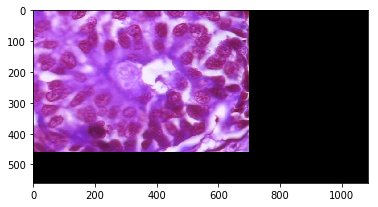

(560, 1086, 3)


In [2]:
import timeit
import cv2
import numpy as np
import matplotlib.pyplot as plt


class Matcher:
    def __init__(self):
        self.surf = cv2.xfeatures2d.SURF_create()
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)

    def match(self, i1, i2):
        image_set_1 = self.get_SURF_features(i1)
        image_set_2 = self.get_SURF_features(i2)
        matches = self.flann.knnMatch(image_set_2["des"], image_set_1["des"], k=2)
        good = []
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                good.append((m.trainIdx, m.queryIdx))

        if len(good) > 4:
            points_current = image_set_2["kp"]
            points_previous = image_set_1["kp"]

            matched_points_current = np.float32(
                [points_current[i].pt for (__, i) in good]
            )
            matched_points_prev = np.float32(
                [points_previous[i].pt for (i, __) in good]
            )

            H, _ = cv2.findHomography(
                matched_points_current, matched_points_prev, cv2.RANSAC, 4
            )
            return H
        return None

    def get_SURF_features(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.surf.detectAndCompute(gray, None)
        return {"kp": kp, "des": des}


class Stitcher:
    def __init__(
        self,
        number_of_images,
        crop_x_min=None,
        crop_x_max=None,
        crop_y_min=None,
        crop_y_max=None,
    ):

        self.matcher_obj = Matcher()
        self.homography_cache = {}
        self.overlay_cache = {}

        self.count = number_of_images

        self.crop_x_min = crop_x_min
        self.crop_x_max = crop_x_max
        self.crop_y_min = crop_y_min
        self.crop_y_max = crop_y_max

    def stitch(self, images=[]):
        """
        stitches the images into a panorama
        """
        self.images = images

        self.prepare_lists()

        # left stitching
        start = timeit.default_timer()
        self.left_shift()
        self.right_shift()
        stop = timeit.default_timer()
        duration = stop - start
        print("stitching took %.2f seconds." % duration)

        if self.crop_x_min and self.crop_x_max and self.crop_y_min and self.crop_y_max:
            return self.result[
                self.crop_y_min : self.crop_y_max, self.crop_x_min : self.crop_x_max
            ]
        else:
            return self.result

    def prepare_lists(self):

        # reset lists
        self.left_list = []
        self.right_list = []

        self.center_index = int(self.count / 2)

        self.result = self.images[self.center_index]

        for i in range(self.count):
            if i <= self.center_index:
                self.left_list.append(self.images[i])
            else:
                self.right_list.append(self.images[i])

    def get_homography(self, image_1, image_1_key, image_2, image_2_key, direction):
        # TODO: use image indexes from the input array
        """
        Calculate the homography matrix between two images.
        Return from cache if possible.
        Args:
            image_1 (np.array) - first image
            image_1_key (str) - identifier for cache
            image_2 (np.array) - second image
            image_2_key (str) - identifier for cache
            direction (str) - "left" or "right"
        Returns:
            homography (np.array) - Homograpy Matrix
        """

        cache_key = "_".join([image_1_key, image_2_key, direction])
        homography = self.homography_cache.get(cache_key, None)
        if homography is None:
            # TODO: is the homography the same regardless of order??
            homography = self.matcher_obj.match(image_1, image_2)
            # put in cache
            self.homography_cache[cache_key] = homography
        return homography

    def left_shift(self):
        """
        stitch images center to left
        """
        # start off with center image
        a = self.left_list[0]

        for i, image in enumerate(self.left_list[1:]):
            H = self.get_homography(a, str(i), image, str(i + 1), "left")

            # inverse homography
            XH = np.linalg.inv(H)

            ds = np.dot(XH, np.array([a.shape[1], a.shape[0], 1]))
            ds = ds / ds[-1]

            f1 = np.dot(XH, np.array([0, 0, 1]))
            f1 = f1 / f1[-1]

            XH[0][-1] += abs(f1[0])
            XH[1][-1] += abs(f1[1])

            ds = np.dot(XH, np.array([a.shape[1], a.shape[0], 1]))
            offsety = abs(int(f1[1]))
            offsetx = abs(int(f1[0]))

            # dimension of warped image
            dsize = (int(ds[0]) + offsetx + 100, int(ds[1]) + offsety + 100)

            tmp = cv2.warpPerspective(a, XH, dsize)

            # punch the image in there
            tmp[
                offsety : image.shape[0] + offsety, offsetx : image.shape[1] + offsetx
            ] = image

            a = tmp

        self.result = tmp

    def right_shift(self):
        """
        stitch images center to right
        """
        for i, imageRight in enumerate(self.right_list):
            imageLeft = self.result

            H = self.get_homography(imageLeft, str(i), imageRight, str(i + 1), "right")

            # args: original_image, matrix, output shape (width, height)
            result = cv2.warpPerspective(
                imageRight,
                H,
                (imageLeft.shape[1] + imageRight.shape[1], imageLeft.shape[0])
            )

            mask = np.zeros((result.shape[0], result.shape[1], 3), dtype="uint8")
            mask[0 : imageLeft.shape[0], 0 : imageLeft.shape[1]] = imageLeft
            self.result = self.blend_images(mask, result, str(i))

    def blend_images(self, background, foreground, i):
        """
        inspired by this answer:
        https://stackoverflow.com/a/54129424/1909378
        """

        only_right = self.overlay_cache.get(i, None)
        if only_right is None:
            only_right = np.nonzero(
                (np.sum(foreground, 2) != 0) * (np.sum(background, 2) == 0)
            )
            self.overlay_cache[i] = only_right

        background[only_right] = foreground[only_right]
        return background


if __name__ == "__main__":
#     FRAME_WIDTH = 700
#     FRAME_HEIGHT = 460

    shanghai_files = [
        "img400x_1.png",
        "img400x_2.png",
        "img400x_3.png",
    ]

    shanghai = [
#         cv2.resize(cv2.imread(f), (FRAME_WIDTH, FRAME_HEIGHT)) for f in shanghai_files
#         cv2.resize(cv2.imread(f), f.shape) for f in shanghai_files
        cv2.imread(f) for f in shanghai_files
    ]

#     crop_x_min = 30
#     crop_x_max = 1000
#     crop_y_min = 37
#     crop_y_max = 1000

    s = Stitcher(
        len(shanghai_files),
#         crop_x_min=crop_x_min,
#         crop_x_max=crop_x_max,
#         crop_y_min=crop_y_min,
#         crop_y_max=crop_y_max,
    )

    panorama = s.stitch(shanghai)
    
    plt.imshow(panorama)
    plt.show()
    
    print(panorama.shape)
    
    

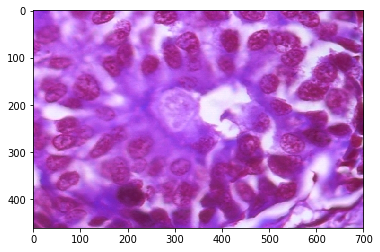

In [3]:
gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
_, tresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

image, contours, hierarchy = cv2.findContours(tresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)

crop = panorama[y:y+h,x:x+w]
# cv2.imwrite('result.png',crop)

plt.imshow(crop)
plt.show()
    